# <center> **-- Deep Convolutional Generative Adversarial Network --** </center>

<br/>

## <font size="20"> &#10148; </font> Introduction

- In this work, a deep convolutional generative adversarial network is trained. The model architecture is an expansion on the original DCGAN architecture in [<em>`Unsupervised Representation Learning with Deep Convolutional Generative Adversarial Networks`</em>](https://arxiv.org/abs/1511.06434). With the enhancement in model architecture, the model is capable of generating images of 128 * 128 resolution (originally 64 * 64). We train the DCGAN on a fraction of the [<em> `Large-scale CelebFaces Attributes (CelebA) Dataset` </em>](https://mmlab.ie.cuhk.edu.hk/projects/CelebA.html), a image dataset contains 202,599 number of face images, with binary attributes (labels are **NOT** used in this work).
- This notebook contains a pipeline for training the original DCGAN (for outputing 64 *64 size image)
- Images from the dataset are 178 * 218 , and is adjusted to 64 *64 (via CenterCrop function from cv2). 
- The model is trained on a single A100 GPU for 100 epoches. It takes around <span style="color:red"> **2 hours**</span> to finish the training. 
- Due to very limited time we have to finish this project, we didn't perform much hyperparameter tuning. We use the learning rate from reproduced original DCGAN found online.
- Images generated showed good performance of the model.

<br/>

## <font size="20"> &#8681; </font> Import

In [73]:
# import
#--------------------------------------------------#
import os 
import sys
import os.path
from sys import platform
from pathlib import Path
#--------------------------------------------------#
import re
import sys
import time
import copy
import math
import html
import scipy
import pickle
import random
import argparse
import subprocess
import numpy as np
import pandas as pd

#--------------------------------------------------#
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as tt

from torchvision.utils import make_grid
from torchvision.utils import save_image
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder

#--------------------------------------------------#
import cv2

#--------------------------------------------------#
from tqdm.notebook import tqdm

#--------------------------------------------------#
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt

#--------------------------------------------------#
%matplotlib inline


#--------------------------------------------------#
# Ensure reproducibility.
seed = 42 # 42, 0, 1, 2, 3, 4
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)


<br/>

## <font size="20"> &#8681; </font> Load Dataset

In [74]:
# Load dataset from the root dir.
data_folder = "./input/celeba"
print("Some image names: ", os.listdir(data_folder)[:5])


# Basic Settings for Training/Model.
batch_size      = 512       # Batch size for training the model. 
image_size      = 64        # Image size to be transformed into. 
stats           = (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)


# These detailed settings of the model are specified in later block.
# num_channel     = 3         # Number of channels (for color images num_channel = 3)
# size_latent     = 128       # Size of z latent vector.
# size_feat_map_g = 64        # Size of feature maps in generator.
# size_feat_map_d = 64        # Size of feature maps in discriminator.
# num_epochs      = 60        # Number of training epochs.
# lr              = 0.0002    # Learning rate. 
# beta1           = 0.5       # Beta1 hyperparam for Adam optimizers.


# Load Image dataset. 
train_ds = ImageFolder(data_folder, transform = tt.Compose([ tt.Resize    (image_size) ,
                                                             tt.CenterCrop(image_size) ,
                                                             tt.ToTensor  ()           ,
                                                             tt.Normalize (*stats)     , ])
                       )  


# Load into DataLoader.
train_dl = DataLoader(train_ds, batch_size, shuffle = True, num_workers = 4, pin_memory = True)

Some image names:  ['000001.jpg', '000002.jpg', '000003.jpg', '000004.jpg', '000005.jpg']


## <font size="20"> &#8681; </font> Define functions for showing the images

In [75]:

def denorm(img_tensors):
    return img_tensors * stats[1][0] + stats[0][0]

def show_images(images, nmax = 64):
    fig, ax = plt.subplots(figsize = (6, 6))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(denorm(images.detach()[ : nmax ]), nrow = 6).permute(1, 2, 0))
    return 




## <font size="20"> &#8681; </font> Load data into device with CPU/GPU compatibility

In [76]:
def is_cuda_available():
    if torch.cuda.is_available():
        print("CUDA available. Training on GPU!")
        return torch.device('cuda')
    else:
        print("CUDA not available. Training on CPU!")
        return torch.device('cpu')

def to_device(data, device):
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        return len(self.dl)


device = is_cuda_available()

train_dl = DeviceDataLoader(train_dl, device)

CUDA available. Training on GPU!


## <font size="20"> &#8681; </font> Model Settings

In [77]:
num_channel     = 3         # Number of channels (for color images num_channel = 3)
size_latent     = 128       # Size of z latent vector.
size_feat_map_g = 64        # Size of feature maps in generator.
size_feat_map_d = 64        # Size of feature maps in discriminator.
num_epochs      = 60        # Number of training epochs.
lr              = 0.0002    # Learning rate. 
beta1           = 0.5       # Beta1 hyperparam for Adam optimizers.

## <font size="20"> &#8681; </font> Define Discriminator

In [78]:
# CNN with Convolutional layers.
discriminator = nn.Sequential(

    # in: 3 x 64 x 64
    nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 64 x 32 x 32

    nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 128 x 16 x 16

    nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 256 x 8 x 8

    nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(512),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 512 x 4 x 4

    nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=0, bias=False),
    # out: 1 x 1 x 1

    nn.Flatten(),
    nn.Sigmoid())

discriminator = to_device(discriminator, device)

## &#10148; Define Generator

In [79]:
# CNN with Convolutional layers.
latent_size = size_latent

generator = nn.Sequential(

    # in: latent_size x 1 x 1
    nn.ConvTranspose2d(latent_size, 512, kernel_size=4, stride=1, padding=0, bias=False),
    nn.BatchNorm2d(512),
    nn.ReLU(True),
    # out: 512 x 4 x 4

    nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.ReLU(True),
    # out: 256 x 8 x 8

    nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.ReLU(True),
    # out: 128 x 16 x 16

    nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.ReLU(True),
    # out: 64 x 32 x 32

    nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1, bias=False),
    nn.Tanh()
    # out: 3 x 64 x 64
)


random_latent_vector = torch.randn(batch_size, size_latent, 1, 1) 
fake_images = generator(random_latent_vector)
print("Shape of fake image: ", fake_images.shape)

generator = to_device(generator, device)



Shape of fake image:  torch.Size([512, 3, 64, 64])


## <font size="20"> &#8681; </font> Function To Train Discriminator

- Initialize gradients.
- Pass real images through discriminator.
- Generate fake images.
- Pass fake images through discriminator.
- Update discriminator weights.
- Save the model parameters for future use.

In [80]:

def train_discriminator(real_img, optimizer_discriminator, epoch_num = 0, if_save = False ):

    # Initialize gradients
    optimizer_discriminator.zero_grad()

    # Pass real images through discriminator
    real_preds   = discriminator(real_img)
    real_targets = torch.ones(real_img.size(0), 1, device = device)
    real_loss    = F.binary_cross_entropy(real_preds, real_targets)
    real_score   = torch.mean(real_preds).item()
    
    # Generate fake images
    latent = torch.randn(batch_size, size_latent, 1, 1, device=device)
    fake_images = generator(latent)


    # Pass fake images through discriminator
    fake_targets = torch.zeros(fake_images.size(0), 1, device=device)
    fake_preds   = discriminator(fake_images)
    fake_loss    = F.binary_cross_entropy(fake_preds, fake_targets)
    fake_score   = torch.mean(fake_preds).item()


    # Update discriminator weights
    loss = real_loss + fake_loss
    loss.backward()
    optimizer_discriminator.step()
    
    # Save the model for later image generation.
    # if if_save:
    #     torch.save(generator.state_dict(), 'Saving_folder/generator_celeba_' + str(epoch_num) + '.pt')

    return loss.item(), real_score, fake_score

## <font size="20"> &#8681; </font> Function To Train Generator

- Initiate generator gradients
- Generate fake images
- Try to fool the discriminator
- Update generator weights

In [81]:

def train_generator(optimizer_generator):
    # Initiate generator gradients
    optimizer_generator.zero_grad()
    
    # Generate fake images
    latent = torch.randn(batch_size, size_latent, 1, 1, device=device)
    fake_images = generator(latent)
    
    # Try to fool the discriminator
    preds = discriminator(fake_images)
    targets = torch.ones(batch_size, 1, device=device)
    loss = F.binary_cross_entropy(preds, targets)
    
    # Update generator weights
    loss.backward()
    optimizer_generator.step()
    
    return loss.item()


## <font size="20"> &#8681; </font> Function To Save the Sample Output.

In [82]:

def save_samples(index, latent_tensors, show = True):
    fake_images = generator(latent_tensors)
    fake_img_nme = 'generated-images-{0:0=4d}.png'.format(index)
    save_image(denorm(fake_images), os.path.join(image_folder, fake_img_nme), nrow = 6)
    print('Saving', fake_img_nme)
    if show:
        fig, ax = plt.subplots(figsize=(6, 6))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(fake_images.cpu().detach(), nrow = 6).permute(1, 2, 0))


image_folder = 'generated'

os.makedirs(image_folder, exist_ok = True)

fixed_latent = torch.randn(36, size_latent, 1, 1, device = device)

save_samples(0, fixed_latent, show = False)

print()

Saving generated-images-0000.png



## <font size="20"> &#8681; </font> Function to Run Training.

In [83]:

def fit(epochs, lr, start_idx=1):
    torch.cuda.empty_cache()
    
    # Losses & scores
    losses_g = []
    losses_d = []
    real_scores = []
    fake_scores = []
    
    # Create optimizers
    optimizer_discriminator = torch.optim.Adam(discriminator.parameters(), lr = lr, betas = (0.5, 0.999))
    optimizer_generator = torch.optim.Adam(generator    .parameters(), lr = lr, betas = (0.5, 0.999))
    
    for epoch in range(epochs):
        for idx, (real_img, _) in enumerate(tqdm(train_dl)):
            if idx == 0:
                print("First Image of this Epoch, Save a temp Model.")
                if_save = True
            else:
                if_save = False
            # Train discriminator
            loss_d, real_score, fake_score = train_discriminator(real_img, optimizer_discriminator, epoch_num = epoch, if_save = if_save)
            # Train generator
            loss_g = train_generator(optimizer_generator)
            
        # Save to list. 
        losses_g.append(loss_g)
        losses_d.append(loss_d)
        real_scores.append(real_score)
        fake_scores.append(fake_score)
        
        # Log losses & scores (last batch)
        print("Epoch [{}/{}], loss_g: {:.4f}, loss_d: {:.4f}, real_score: {:.4f}, fake_score: {:.4f}".format(
            epoch + 1, epochs, loss_g, loss_d, real_score, fake_score))
    
        # Save generated images
        save_samples(epoch + start_idx, fixed_latent, show = False)

        torch.save(generator.state_dict(), 'Saving_folder/generator_celeba_' + str(epoch) + '.pt')
        
    return losses_g, losses_d, real_scores, fake_scores

## <font size="20"> &#8681; </font> Run Train.

- Training the model requires some good computation resources.
- We have used a A100 GPU (w/ 40GB VRAM) and a system that guarantees 186GB RAM.
- Training a orginal DCGAN (64 x 64) takes less than 2 hour on A100. 


In [84]:
lr = 0.0003
epochs = 100

losses_g, losses_d, real_scores, fake_scores = fit(epochs, lr)

  0%|          | 0/396 [00:00<?, ?it/s]

First Image of this Epoch, Save a temp Model.
Epoch [1/100], loss_g: 5.6835, loss_d: 0.0580, real_score: 0.9694, fake_score: 0.0253
Saving generated-images-0001.png


  0%|          | 0/396 [00:00<?, ?it/s]

First Image of this Epoch, Save a temp Model.
Epoch [2/100], loss_g: 4.3160, loss_d: 0.4203, real_score: 0.8781, fake_score: 0.2225
Saving generated-images-0002.png


  0%|          | 0/396 [00:00<?, ?it/s]

First Image of this Epoch, Save a temp Model.
Epoch [3/100], loss_g: 4.6787, loss_d: 0.6169, real_score: 0.8522, fake_score: 0.3217
Saving generated-images-0003.png


  0%|          | 0/396 [00:00<?, ?it/s]

First Image of this Epoch, Save a temp Model.
Epoch [4/100], loss_g: 2.8778, loss_d: 0.4453, real_score: 0.7629, fake_score: 0.1201
Saving generated-images-0004.png


  0%|          | 0/396 [00:00<?, ?it/s]

First Image of this Epoch, Save a temp Model.
Epoch [5/100], loss_g: 2.9830, loss_d: 0.4090, real_score: 0.7564, fake_score: 0.0901
Saving generated-images-0005.png


  0%|          | 0/396 [00:00<?, ?it/s]

First Image of this Epoch, Save a temp Model.
Epoch [6/100], loss_g: 1.9308, loss_d: 0.4920, real_score: 0.7361, fake_score: 0.1238
Saving generated-images-0006.png


  0%|          | 0/396 [00:00<?, ?it/s]

First Image of this Epoch, Save a temp Model.
Epoch [7/100], loss_g: 5.4781, loss_d: 0.9798, real_score: 0.9674, fake_score: 0.5547
Saving generated-images-0007.png


  0%|          | 0/396 [00:00<?, ?it/s]

First Image of this Epoch, Save a temp Model.
Epoch [8/100], loss_g: 4.7347, loss_d: 0.4818, real_score: 0.9126, fake_score: 0.2897
Saving generated-images-0008.png


  0%|          | 0/396 [00:00<?, ?it/s]

First Image of this Epoch, Save a temp Model.
Epoch [9/100], loss_g: 3.7954, loss_d: 0.2573, real_score: 0.9195, fake_score: 0.1463
Saving generated-images-0009.png


  0%|          | 0/396 [00:00<?, ?it/s]

First Image of this Epoch, Save a temp Model.
Epoch [10/100], loss_g: 3.0976, loss_d: 0.5070, real_score: 0.8088, fake_score: 0.2236
Saving generated-images-0010.png


  0%|          | 0/396 [00:00<?, ?it/s]

First Image of this Epoch, Save a temp Model.
Epoch [11/100], loss_g: 4.0544, loss_d: 1.4150, real_score: 0.9417, fake_score: 0.6484
Saving generated-images-0011.png


  0%|          | 0/396 [00:00<?, ?it/s]

First Image of this Epoch, Save a temp Model.
Epoch [12/100], loss_g: 0.9372, loss_d: 0.8838, real_score: 0.4840, fake_score: 0.0291
Saving generated-images-0012.png


  0%|          | 0/396 [00:00<?, ?it/s]

First Image of this Epoch, Save a temp Model.
Epoch [13/100], loss_g: 1.8368, loss_d: 0.4446, real_score: 0.6976, fake_score: 0.0468
Saving generated-images-0013.png


  0%|          | 0/396 [00:00<?, ?it/s]

First Image of this Epoch, Save a temp Model.
Epoch [14/100], loss_g: 3.2042, loss_d: 0.1976, real_score: 0.8895, fake_score: 0.0698
Saving generated-images-0014.png


  0%|          | 0/396 [00:00<?, ?it/s]

First Image of this Epoch, Save a temp Model.
Epoch [15/100], loss_g: 6.0126, loss_d: 1.3496, real_score: 0.9757, fake_score: 0.6722
Saving generated-images-0015.png


  0%|          | 0/396 [00:00<?, ?it/s]

First Image of this Epoch, Save a temp Model.
Epoch [16/100], loss_g: 2.9598, loss_d: 0.2859, real_score: 0.8106, fake_score: 0.0580
Saving generated-images-0016.png


  0%|          | 0/396 [00:00<?, ?it/s]

First Image of this Epoch, Save a temp Model.
Epoch [17/100], loss_g: 3.0349, loss_d: 0.5197, real_score: 0.8468, fake_score: 0.2621
Saving generated-images-0017.png


  0%|          | 0/396 [00:00<?, ?it/s]

First Image of this Epoch, Save a temp Model.
Epoch [18/100], loss_g: 2.3765, loss_d: 0.4444, real_score: 0.7330, fake_score: 0.0884
Saving generated-images-0018.png


  0%|          | 0/396 [00:00<?, ?it/s]

First Image of this Epoch, Save a temp Model.
Epoch [19/100], loss_g: 2.4700, loss_d: 0.3301, real_score: 0.9008, fake_score: 0.1774
Saving generated-images-0019.png


  0%|          | 0/396 [00:00<?, ?it/s]

First Image of this Epoch, Save a temp Model.
Epoch [20/100], loss_g: 1.8580, loss_d: 0.4462, real_score: 0.7543, fake_score: 0.1237
Saving generated-images-0020.png


  0%|          | 0/396 [00:00<?, ?it/s]

First Image of this Epoch, Save a temp Model.
Epoch [21/100], loss_g: 4.4229, loss_d: 0.3628, real_score: 0.9647, fake_score: 0.2605
Saving generated-images-0021.png


  0%|          | 0/396 [00:00<?, ?it/s]

First Image of this Epoch, Save a temp Model.
Epoch [22/100], loss_g: 4.4176, loss_d: 0.4622, real_score: 0.9594, fake_score: 0.3137
Saving generated-images-0022.png


  0%|          | 0/396 [00:00<?, ?it/s]

First Image of this Epoch, Save a temp Model.
Epoch [23/100], loss_g: 2.5871, loss_d: 0.2724, real_score: 0.8482, fake_score: 0.0872
Saving generated-images-0023.png


  0%|          | 0/396 [00:00<?, ?it/s]

First Image of this Epoch, Save a temp Model.
Epoch [24/100], loss_g: 2.3042, loss_d: 0.4364, real_score: 0.8229, fake_score: 0.1885
Saving generated-images-0024.png


  0%|          | 0/396 [00:00<?, ?it/s]

First Image of this Epoch, Save a temp Model.
Epoch [25/100], loss_g: 1.5276, loss_d: 0.3852, real_score: 0.7358, fake_score: 0.0364
Saving generated-images-0025.png


  0%|          | 0/396 [00:00<?, ?it/s]

First Image of this Epoch, Save a temp Model.
Epoch [26/100], loss_g: 1.6030, loss_d: 0.5199, real_score: 0.6637, fake_score: 0.0574
Saving generated-images-0026.png


  0%|          | 0/396 [00:00<?, ?it/s]

First Image of this Epoch, Save a temp Model.
Epoch [27/100], loss_g: 5.5093, loss_d: 0.4324, real_score: 0.9614, fake_score: 0.2939
Saving generated-images-0027.png


  0%|          | 0/396 [00:00<?, ?it/s]

First Image of this Epoch, Save a temp Model.
Epoch [28/100], loss_g: 1.3677, loss_d: 0.6584, real_score: 0.6031, fake_score: 0.0726
Saving generated-images-0028.png


  0%|          | 0/396 [00:00<?, ?it/s]

First Image of this Epoch, Save a temp Model.
Epoch [29/100], loss_g: 3.2578, loss_d: 0.3579, real_score: 0.9100, fake_score: 0.2051
Saving generated-images-0029.png


  0%|          | 0/396 [00:00<?, ?it/s]

First Image of this Epoch, Save a temp Model.
Epoch [30/100], loss_g: 1.6567, loss_d: 0.3470, real_score: 0.7457, fake_score: 0.0228
Saving generated-images-0030.png


  0%|          | 0/396 [00:00<?, ?it/s]

First Image of this Epoch, Save a temp Model.
Epoch [31/100], loss_g: 2.3272, loss_d: 0.6382, real_score: 0.9147, fake_score: 0.3621
Saving generated-images-0031.png


  0%|          | 0/396 [00:00<?, ?it/s]

First Image of this Epoch, Save a temp Model.
Epoch [32/100], loss_g: 3.3507, loss_d: 0.4262, real_score: 0.8641, fake_score: 0.2114
Saving generated-images-0032.png


  0%|          | 0/396 [00:00<?, ?it/s]

First Image of this Epoch, Save a temp Model.
Epoch [33/100], loss_g: 3.1196, loss_d: 0.2116, real_score: 0.9310, fake_score: 0.1180
Saving generated-images-0033.png


  0%|          | 0/396 [00:00<?, ?it/s]

First Image of this Epoch, Save a temp Model.
Epoch [34/100], loss_g: 3.7350, loss_d: 0.1486, real_score: 0.9382, fake_score: 0.0742
Saving generated-images-0034.png


  0%|          | 0/396 [00:00<?, ?it/s]

First Image of this Epoch, Save a temp Model.
Epoch [35/100], loss_g: 3.2468, loss_d: 0.2460, real_score: 0.9061, fake_score: 0.1236
Saving generated-images-0035.png


  0%|          | 0/396 [00:00<?, ?it/s]

First Image of this Epoch, Save a temp Model.
Epoch [36/100], loss_g: 1.6138, loss_d: 0.3054, real_score: 0.7728, fake_score: 0.0198
Saving generated-images-0036.png


  0%|          | 0/396 [00:00<?, ?it/s]

First Image of this Epoch, Save a temp Model.
Epoch [37/100], loss_g: 4.2806, loss_d: 0.2755, real_score: 0.9149, fake_score: 0.1513
Saving generated-images-0037.png


  0%|          | 0/396 [00:00<?, ?it/s]

First Image of this Epoch, Save a temp Model.
Epoch [38/100], loss_g: 2.1942, loss_d: 2.0403, real_score: 0.8214, fake_score: 0.7905
Saving generated-images-0038.png


  0%|          | 0/396 [00:00<?, ?it/s]

First Image of this Epoch, Save a temp Model.
Epoch [39/100], loss_g: 3.5012, loss_d: 0.3397, real_score: 0.8796, fake_score: 0.1653
Saving generated-images-0039.png


  0%|          | 0/396 [00:00<?, ?it/s]

First Image of this Epoch, Save a temp Model.
Epoch [40/100], loss_g: 5.0171, loss_d: 1.4156, real_score: 0.9676, fake_score: 0.6693
Saving generated-images-0040.png


  0%|          | 0/396 [00:00<?, ?it/s]

First Image of this Epoch, Save a temp Model.
Epoch [41/100], loss_g: 4.1540, loss_d: 0.1414, real_score: 0.9509, fake_score: 0.0806
Saving generated-images-0041.png


  0%|          | 0/396 [00:00<?, ?it/s]

First Image of this Epoch, Save a temp Model.
Epoch [42/100], loss_g: 4.1297, loss_d: 0.3217, real_score: 0.9380, fake_score: 0.2019
Saving generated-images-0042.png


  0%|          | 0/396 [00:00<?, ?it/s]

First Image of this Epoch, Save a temp Model.
Epoch [43/100], loss_g: 6.4107, loss_d: 1.2836, real_score: 0.9916, fake_score: 0.6313
Saving generated-images-0043.png


  0%|          | 0/396 [00:00<?, ?it/s]

First Image of this Epoch, Save a temp Model.
Epoch [44/100], loss_g: 4.8026, loss_d: 0.7360, real_score: 0.9901, fake_score: 0.4574
Saving generated-images-0044.png


  0%|          | 0/396 [00:00<?, ?it/s]

First Image of this Epoch, Save a temp Model.
Epoch [45/100], loss_g: 3.6677, loss_d: 0.0989, real_score: 0.9468, fake_score: 0.0389
Saving generated-images-0045.png


  0%|          | 0/396 [00:00<?, ?it/s]

First Image of this Epoch, Save a temp Model.
Epoch [46/100], loss_g: 0.9325, loss_d: 0.5267, real_score: 0.6409, fake_score: 0.0082
Saving generated-images-0046.png


  0%|          | 0/396 [00:00<?, ?it/s]

First Image of this Epoch, Save a temp Model.
Epoch [47/100], loss_g: 4.5212, loss_d: 0.4136, real_score: 0.9733, fake_score: 0.2740
Saving generated-images-0047.png


  0%|          | 0/396 [00:00<?, ?it/s]

First Image of this Epoch, Save a temp Model.
Epoch [48/100], loss_g: 3.7406, loss_d: 0.0952, real_score: 0.9440, fake_score: 0.0327
Saving generated-images-0048.png


  0%|          | 0/396 [00:00<?, ?it/s]

First Image of this Epoch, Save a temp Model.
Epoch [49/100], loss_g: 3.4473, loss_d: 0.1296, real_score: 0.9410, fake_score: 0.0597
Saving generated-images-0049.png


  0%|          | 0/396 [00:00<?, ?it/s]

First Image of this Epoch, Save a temp Model.
Epoch [50/100], loss_g: 3.7725, loss_d: 0.1172, real_score: 0.9264, fake_score: 0.0349
Saving generated-images-0050.png


  0%|          | 0/396 [00:00<?, ?it/s]

First Image of this Epoch, Save a temp Model.
Epoch [51/100], loss_g: 3.8833, loss_d: 0.1615, real_score: 0.9515, fake_score: 0.0962
Saving generated-images-0051.png


  0%|          | 0/396 [00:00<?, ?it/s]

First Image of this Epoch, Save a temp Model.
Epoch [52/100], loss_g: 3.6458, loss_d: 0.1120, real_score: 0.9258, fake_score: 0.0280
Saving generated-images-0052.png


  0%|          | 0/396 [00:00<?, ?it/s]

First Image of this Epoch, Save a temp Model.
Epoch [53/100], loss_g: 4.0233, loss_d: 0.1408, real_score: 0.9207, fake_score: 0.0492
Saving generated-images-0053.png


  0%|          | 0/396 [00:00<?, ?it/s]

First Image of this Epoch, Save a temp Model.
Epoch [54/100], loss_g: 4.8371, loss_d: 0.1392, real_score: 0.9337, fake_score: 0.0573
Saving generated-images-0054.png


  0%|          | 0/396 [00:00<?, ?it/s]

First Image of this Epoch, Save a temp Model.
Epoch [55/100], loss_g: 2.9593, loss_d: 0.2918, real_score: 0.8486, fake_score: 0.0932
Saving generated-images-0055.png


  0%|          | 0/396 [00:00<?, ?it/s]

First Image of this Epoch, Save a temp Model.
Epoch [56/100], loss_g: 3.9614, loss_d: 0.1409, real_score: 0.9122, fake_score: 0.0372
Saving generated-images-0056.png


  0%|          | 0/396 [00:00<?, ?it/s]

First Image of this Epoch, Save a temp Model.
Epoch [57/100], loss_g: 3.3411, loss_d: 0.3661, real_score: 0.8778, fake_score: 0.1772
Saving generated-images-0057.png


  0%|          | 0/396 [00:00<?, ?it/s]

First Image of this Epoch, Save a temp Model.
Epoch [58/100], loss_g: 4.0654, loss_d: 0.1488, real_score: 0.9280, fake_score: 0.0585
Saving generated-images-0058.png


  0%|          | 0/396 [00:00<?, ?it/s]

First Image of this Epoch, Save a temp Model.
Epoch [59/100], loss_g: 4.1119, loss_d: 0.1168, real_score: 0.9452, fake_score: 0.0501
Saving generated-images-0059.png


  0%|          | 0/396 [00:00<?, ?it/s]

First Image of this Epoch, Save a temp Model.
Epoch [60/100], loss_g: 1.6323, loss_d: 1.1641, real_score: 0.4326, fake_score: 0.0861
Saving generated-images-0060.png


  0%|          | 0/396 [00:00<?, ?it/s]

First Image of this Epoch, Save a temp Model.
Epoch [61/100], loss_g: 4.2764, loss_d: 0.0912, real_score: 0.9737, fake_score: 0.0583
Saving generated-images-0061.png


  0%|          | 0/396 [00:00<?, ?it/s]

First Image of this Epoch, Save a temp Model.
Epoch [62/100], loss_g: 6.7866, loss_d: 2.5492, real_score: 0.9982, fake_score: 0.8241
Saving generated-images-0062.png


  0%|          | 0/396 [00:00<?, ?it/s]

First Image of this Epoch, Save a temp Model.
Epoch [63/100], loss_g: 2.2077, loss_d: 0.5102, real_score: 0.7523, fake_score: 0.1336
Saving generated-images-0063.png


  0%|          | 0/396 [00:00<?, ?it/s]

First Image of this Epoch, Save a temp Model.
Epoch [64/100], loss_g: 4.6734, loss_d: 0.0773, real_score: 0.9890, fake_score: 0.0607
Saving generated-images-0064.png


  0%|          | 0/396 [00:00<?, ?it/s]

First Image of this Epoch, Save a temp Model.
Epoch [65/100], loss_g: 4.8280, loss_d: 0.0704, real_score: 0.9720, fake_score: 0.0382
Saving generated-images-0065.png


  0%|          | 0/396 [00:00<?, ?it/s]

First Image of this Epoch, Save a temp Model.
Epoch [66/100], loss_g: 4.0402, loss_d: 0.1853, real_score: 0.9208, fake_score: 0.0782
Saving generated-images-0066.png


  0%|          | 0/396 [00:00<?, ?it/s]

First Image of this Epoch, Save a temp Model.
Epoch [67/100], loss_g: 1.8139, loss_d: 0.2989, real_score: 0.7774, fake_score: 0.0126
Saving generated-images-0067.png


  0%|          | 0/396 [00:00<?, ?it/s]

First Image of this Epoch, Save a temp Model.
Epoch [68/100], loss_g: 3.7904, loss_d: 1.0422, real_score: 0.9043, fake_score: 0.5227
Saving generated-images-0068.png


  0%|          | 0/396 [00:00<?, ?it/s]

First Image of this Epoch, Save a temp Model.
Epoch [69/100], loss_g: 6.5365, loss_d: 0.2572, real_score: 0.9902, fake_score: 0.1889
Saving generated-images-0069.png


  0%|          | 0/396 [00:00<?, ?it/s]

First Image of this Epoch, Save a temp Model.
Epoch [70/100], loss_g: 4.7048, loss_d: 0.1515, real_score: 0.9634, fake_score: 0.0967
Saving generated-images-0070.png


  0%|          | 0/396 [00:00<?, ?it/s]

First Image of this Epoch, Save a temp Model.
Epoch [71/100], loss_g: 4.4442, loss_d: 0.0693, real_score: 0.9570, fake_score: 0.0226
Saving generated-images-0071.png


  0%|          | 0/396 [00:00<?, ?it/s]

First Image of this Epoch, Save a temp Model.
Epoch [72/100], loss_g: 4.4307, loss_d: 0.3919, real_score: 0.9300, fake_score: 0.2237
Saving generated-images-0072.png


  0%|          | 0/396 [00:00<?, ?it/s]

First Image of this Epoch, Save a temp Model.
Epoch [73/100], loss_g: 3.2745, loss_d: 0.1108, real_score: 0.9530, fake_score: 0.0549
Saving generated-images-0073.png


  0%|          | 0/396 [00:00<?, ?it/s]

First Image of this Epoch, Save a temp Model.
Epoch [74/100], loss_g: 1.4655, loss_d: 0.5790, real_score: 0.6800, fake_score: 0.1005
Saving generated-images-0074.png


  0%|          | 0/396 [00:00<?, ?it/s]

First Image of this Epoch, Save a temp Model.
Epoch [75/100], loss_g: 3.3808, loss_d: 0.2891, real_score: 0.9711, fake_score: 0.1964
Saving generated-images-0075.png


  0%|          | 0/396 [00:00<?, ?it/s]

First Image of this Epoch, Save a temp Model.
Epoch [76/100], loss_g: 3.1462, loss_d: 0.1804, real_score: 0.9591, fake_score: 0.1127
Saving generated-images-0076.png


  0%|          | 0/396 [00:00<?, ?it/s]

First Image of this Epoch, Save a temp Model.
Epoch [77/100], loss_g: 4.1958, loss_d: 0.0735, real_score: 0.9527, fake_score: 0.0216
Saving generated-images-0077.png


  0%|          | 0/396 [00:00<?, ?it/s]

First Image of this Epoch, Save a temp Model.
Epoch [78/100], loss_g: 1.9340, loss_d: 0.7003, real_score: 0.6224, fake_score: 0.0875
Saving generated-images-0078.png


  0%|          | 0/396 [00:00<?, ?it/s]

First Image of this Epoch, Save a temp Model.
Epoch [79/100], loss_g: 4.8493, loss_d: 0.0708, real_score: 0.9728, fake_score: 0.0376
Saving generated-images-0079.png


  0%|          | 0/396 [00:00<?, ?it/s]

First Image of this Epoch, Save a temp Model.
Epoch [80/100], loss_g: 4.5670, loss_d: 0.1583, real_score: 0.8897, fake_score: 0.0248
Saving generated-images-0080.png


  0%|          | 0/396 [00:00<?, ?it/s]

First Image of this Epoch, Save a temp Model.
Epoch [81/100], loss_g: 3.3665, loss_d: 0.2022, real_score: 0.8700, fake_score: 0.0379
Saving generated-images-0081.png


  0%|          | 0/396 [00:00<?, ?it/s]

First Image of this Epoch, Save a temp Model.
Epoch [82/100], loss_g: 5.5258, loss_d: 0.1024, real_score: 0.9861, fake_score: 0.0758
Saving generated-images-0082.png


  0%|          | 0/396 [00:00<?, ?it/s]

First Image of this Epoch, Save a temp Model.
Epoch [83/100], loss_g: 3.7180, loss_d: 0.0996, real_score: 0.9432, fake_score: 0.0358
Saving generated-images-0083.png


  0%|          | 0/396 [00:00<?, ?it/s]

First Image of this Epoch, Save a temp Model.
Epoch [84/100], loss_g: 4.2875, loss_d: 0.1022, real_score: 0.9734, fake_score: 0.0653
Saving generated-images-0084.png


  0%|          | 0/396 [00:00<?, ?it/s]

First Image of this Epoch, Save a temp Model.
Epoch [85/100], loss_g: 4.9425, loss_d: 0.1420, real_score: 0.9644, fake_score: 0.0880
Saving generated-images-0085.png


  0%|          | 0/396 [00:00<?, ?it/s]

First Image of this Epoch, Save a temp Model.
Epoch [86/100], loss_g: 4.3851, loss_d: 0.1294, real_score: 0.9081, fake_score: 0.0230
Saving generated-images-0086.png


  0%|          | 0/396 [00:00<?, ?it/s]

First Image of this Epoch, Save a temp Model.
Epoch [87/100], loss_g: 4.6269, loss_d: 0.1559, real_score: 0.9508, fake_score: 0.0851
Saving generated-images-0087.png


  0%|          | 0/396 [00:00<?, ?it/s]

First Image of this Epoch, Save a temp Model.
Epoch [88/100], loss_g: 4.9041, loss_d: 0.0885, real_score: 0.9644, fake_score: 0.0450
Saving generated-images-0088.png


  0%|          | 0/396 [00:00<?, ?it/s]

First Image of this Epoch, Save a temp Model.
Epoch [89/100], loss_g: 4.3297, loss_d: 0.1211, real_score: 0.9472, fake_score: 0.0569
Saving generated-images-0089.png


  0%|          | 0/396 [00:00<?, ?it/s]

First Image of this Epoch, Save a temp Model.
Epoch [90/100], loss_g: 2.2370, loss_d: 0.5832, real_score: 0.7196, fake_score: 0.1440
Saving generated-images-0090.png


  0%|          | 0/396 [00:00<?, ?it/s]

First Image of this Epoch, Save a temp Model.
Epoch [91/100], loss_g: 4.3999, loss_d: 0.0919, real_score: 0.9726, fake_score: 0.0561
Saving generated-images-0091.png


  0%|          | 0/396 [00:00<?, ?it/s]

First Image of this Epoch, Save a temp Model.
Epoch [92/100], loss_g: 4.3941, loss_d: 0.0887, real_score: 0.9431, fake_score: 0.0242
Saving generated-images-0092.png


  0%|          | 0/396 [00:00<?, ?it/s]

First Image of this Epoch, Save a temp Model.
Epoch [93/100], loss_g: 2.1440, loss_d: 0.3068, real_score: 0.8115, fake_score: 0.0552
Saving generated-images-0093.png


  0%|          | 0/396 [00:00<?, ?it/s]

First Image of this Epoch, Save a temp Model.
Epoch [94/100], loss_g: 4.6699, loss_d: 0.0935, real_score: 0.9625, fake_score: 0.0422
Saving generated-images-0094.png


  0%|          | 0/396 [00:00<?, ?it/s]

First Image of this Epoch, Save a temp Model.
Epoch [95/100], loss_g: 4.1972, loss_d: 0.1161, real_score: 0.9404, fake_score: 0.0433
Saving generated-images-0095.png


  0%|          | 0/396 [00:00<?, ?it/s]

First Image of this Epoch, Save a temp Model.
Epoch [96/100], loss_g: 3.9105, loss_d: 0.0730, real_score: 0.9509, fake_score: 0.0166
Saving generated-images-0096.png


  0%|          | 0/396 [00:00<?, ?it/s]

First Image of this Epoch, Save a temp Model.
Epoch [97/100], loss_g: 3.4286, loss_d: 0.1085, real_score: 0.9801, fake_score: 0.0758
Saving generated-images-0097.png


  0%|          | 0/396 [00:00<?, ?it/s]

First Image of this Epoch, Save a temp Model.
Epoch [98/100], loss_g: 4.3227, loss_d: 0.1113, real_score: 0.9278, fake_score: 0.0277
Saving generated-images-0098.png


  0%|          | 0/396 [00:00<?, ?it/s]

First Image of this Epoch, Save a temp Model.
Epoch [99/100], loss_g: 4.6329, loss_d: 0.1785, real_score: 0.9507, fake_score: 0.1032
Saving generated-images-0099.png


  0%|          | 0/396 [00:00<?, ?it/s]

First Image of this Epoch, Save a temp Model.
Epoch [100/100], loss_g: 2.3691, loss_d: 0.4784, real_score: 0.8266, fake_score: 0.1889
Saving generated-images-0100.png


## <font size="20"> &#8681; </font> Print out the Losses and Scores and Save. 

In [85]:

print(losses_d   )
print(losses_g   )
print(fake_scores)
print(real_scores)

[0.0580240897834301, 0.4203268885612488, 0.6168571710586548, 0.44527724385261536, 0.409023642539978, 0.4920249879360199, 0.9798041582107544, 0.48184457421302795, 0.2572633624076843, 0.5070317387580872, 1.415022373199463, 0.8838130235671997, 0.4445694088935852, 0.19758765399456024, 1.3496376276016235, 0.2859329879283905, 0.5196765661239624, 0.44438499212265015, 0.3301272690296173, 0.44616490602493286, 0.3627839684486389, 0.4622069001197815, 0.27242279052734375, 0.4363623857498169, 0.38524457812309265, 0.5198970437049866, 0.4324421286582947, 0.6584209203720093, 0.35786011815071106, 0.3470483422279358, 0.6381525993347168, 0.4262174367904663, 0.21164479851722717, 0.14862671494483948, 0.2460203766822815, 0.3054083585739136, 0.27548274397850037, 2.040300130844116, 0.3397144675254822, 1.4155927896499634, 0.1413925141096115, 0.321727991104126, 1.2836010456085205, 0.7360451817512512, 0.09894926846027374, 0.5267089605331421, 0.4135552644729614, 0.09522439539432526, 0.1296188235282898, 0.11722921

## <font size="20"> &#8681; </font> Display image generated in the middle of training.

One Fake generated image:

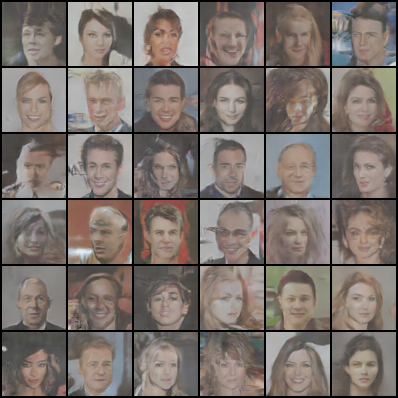

In [86]:
# Display an intermediate image.

from IPython.display import Image
Image('./generated/generated-images-0037.png')

## <font size="20"> &#8681; </font> Make the Images Generated in Each Epoch into a Video.

In [88]:
# Generate a video.

video_files_list = [os.path.join(image_folder, f) for f in os.listdir(image_folder) if 'generated' in f]
video_files_list.sort()

video_files_list = video_files_list + [video_files_list[-1] for i in range(30)]

video_out = cv2.VideoWriter('DCGAN_Training.avi',                                              # Video Name.
                            cv2.VideoWriter_fourcc(*'MP4V'),                                   # format.
                            5,                                                                 # Number of images per second. 
                            ( (image_size * 6 + 2 * (6+1) ) , (image_size * 6 + 2 * (6+1) ))   # Size of video has to match the image size.
                            )

[video_out.write(cv2.imread(video_file)) for video_file in video_files_list]
video_out.release()


## <font size="20"> &#8681; </font> Make a Plot Based on Saved Losses

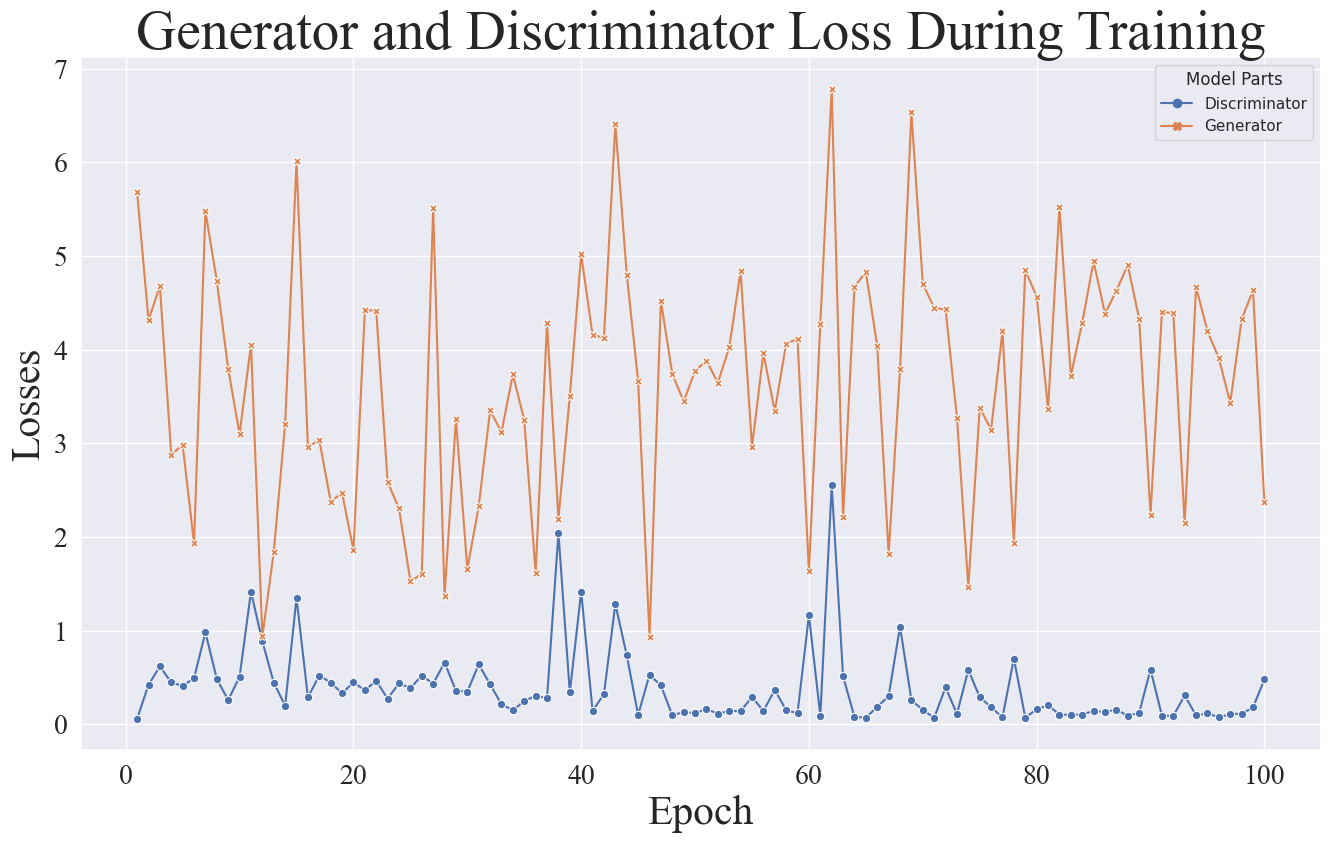

In [89]:
# Load saved training results.
# losses_d    = []
# losses_g    = []
# fake_scores = []
# real_scores = []

# Create a DF for plotting the losses.
losses_list = losses_d + losses_g
hue_list    = ["Discriminator"] * len(losses_d) + ["Generator"] * len(losses_g)
epoch_list  = [i+1 for i in range(len(losses_d))] + [i+1 for i in range(len(losses_d))] 

import pandas as pd
df_losses = pd.DataFrame({'Losses' : losses_list , 'Model Parts' : hue_list, 'Epoch' : epoch_list})

output_file_header = "Saving_Plot_Losses_DCGAN_"

fig= plt.figure(figsize=(16, 9))
main_color = sns.color_palette("autumn", 6)

sns.set(style = "darkgrid")

ax = sns.lineplot(data = df_losses,
                  x = "Epoch", y = "Losses", hue = "Model Parts", style = "Model Parts",
                  markers=True, dashes=False
                  )
#--------------------------------------------------#
font = {'family' : "Times New Roman"}
plt.rc('font', **font)
mpl.rc('font', family = 'serif', serif = "Times New Roman")
#--------------------------------------------------#
plt.rc('font', **font)
plt.rc('font', size = 20)             # controls default text sizes
plt.rc('axes', titlesize = 20)        # fontsize of the axes title
plt.rc('axes', labelsize = 20)        # fontsize of the x and y labels
#--------------------------------------------------#
plt.rc('xtick',  labelsize = 20, )    # fontsize of the tick labels
plt.rc('ytick',  labelsize = 20, )    # fontsize of the tick labels
plt.rc('legend', fontsize  = 20, )    # legend fontsize
plt.rc('figure', titlesize = 20, )    # fontsize of the figure title
#--------------------------------------------------#
plt.xticks(fontsize = 20, rotation = 0, **font)
plt.yticks(fontsize = 20, **font)
#--------------------------------------------------#
x_title = "Epoch"
y_title = "Losses"
p_title = 'Generator and Discriminator Loss During Training'
#--------------------------------------------------#
plt.xlabel(x_title, fontsize = 30, **font)
plt.ylabel(y_title, fontsize = 30, **font)
plt.title (p_title, fontsize = 40, **font)
#--------------------------------------------------#
plt.rc('font', **font)
mpl.rc('font', family = 'serif', serif = "Times New Roman")
#--------------------------------------------------#
folder = Path("./") 
fig.savefig(folder / (output_file_header + "_barplot_" + ".png") , dpi = 500 ) 
mpl.rcParams.update(mpl.rcParamsDefault)
plt.show()




## <font size="20"> &#8681; </font> Make a Plot Based on Saved Scores of Discriminators and Generators

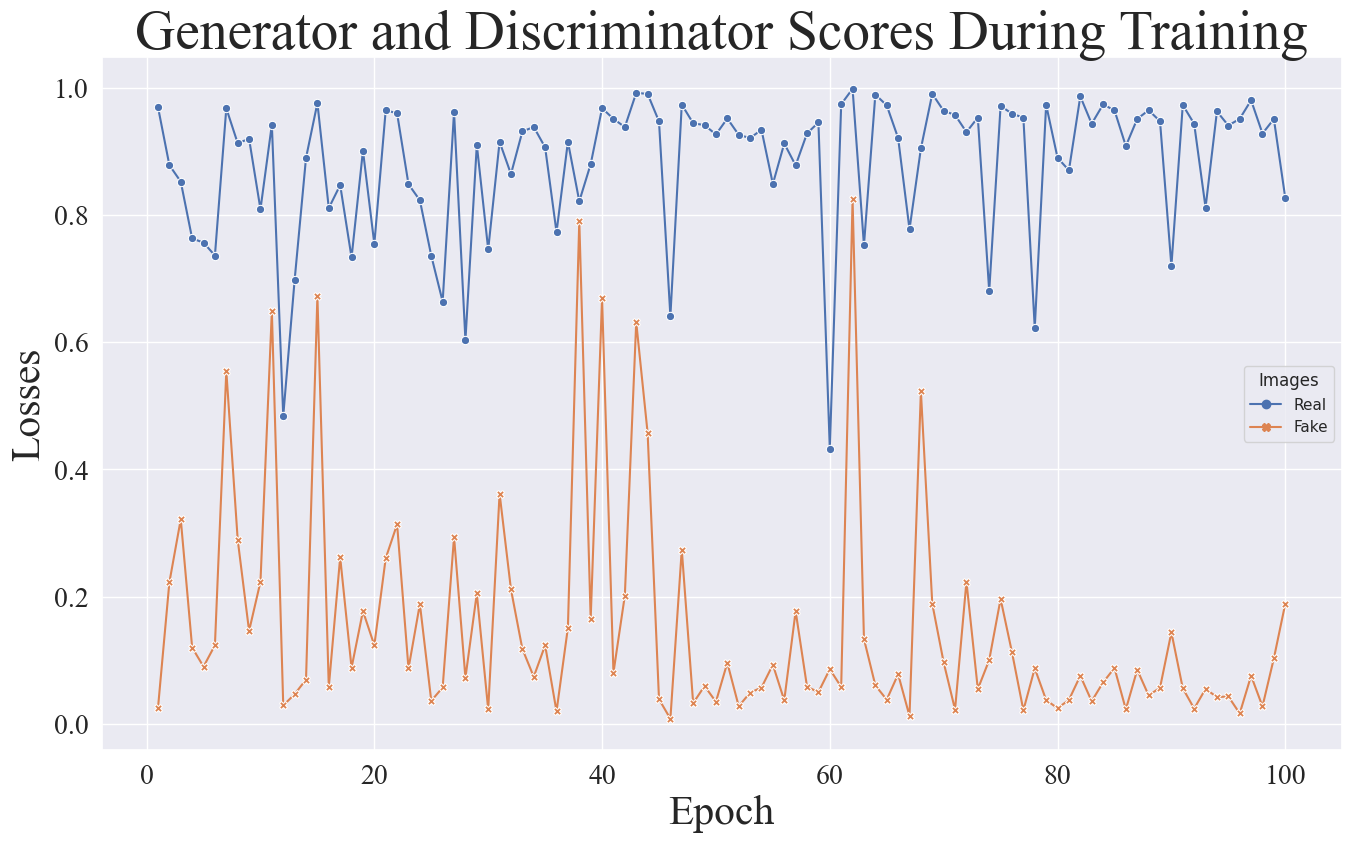

In [90]:


# Create a DF for plotting the losses.
scores_list = real_scores + fake_scores
hue_list    = ["Real"] * len(real_scores) + ["Fake"] * len(fake_scores)
epoch_list  = [i+1 for i in range(len(real_scores))] + [i+1 for i in range(len(fake_scores))] 

df_scores = pd.DataFrame({'Scores' : scores_list , 'Images' : hue_list, 'Epoch' : epoch_list})

output_file_header = "Saving_Plot_Scores_DCGAN_"

fig= plt.figure(figsize=(16, 9))
main_color = sns.color_palette("autumn", 6)

sns.set(style = "darkgrid")

ax = sns.lineplot(data = df_scores,
                  x = "Epoch", y = "Scores", hue = "Images", style = "Images",
                  markers=True, dashes=False
                  )

#--------------------------------------------------#
font = {'family' : "Times New Roman"}
plt.rc('font', **font)
mpl.rc('font', family = 'serif', serif = "Times New Roman")
#--------------------------------------------------#
plt.rc('font', **font)
plt.rc('font', size = 20)             # controls default text sizes
plt.rc('axes', titlesize = 20)        # fontsize of the axes title
plt.rc('axes', labelsize = 20)        # fontsize of the x and y labels
#--------------------------------------------------#
plt.rc('xtick',  labelsize = 20, )    # fontsize of the tick labels
plt.rc('ytick',  labelsize = 20, )    # fontsize of the tick labels
plt.rc('legend', fontsize  = 20, )    # legend fontsize
plt.rc('figure', titlesize = 20, )    # fontsize of the figure title
#--------------------------------------------------#
plt.xticks(fontsize = 20, rotation = 0, **font)
plt.yticks(fontsize = 20, **font)
#--------------------------------------------------#
x_title = "Epoch"
y_title = "Losses"
p_title = 'Generator and Discriminator Scores During Training'
#--------------------------------------------------#
plt.xlabel(x_title, fontsize = 30, **font)
plt.ylabel(y_title, fontsize = 30, **font)
plt.title (p_title, fontsize = 40, **font)
#--------------------------------------------------#
plt.rc('font', **font)
mpl.rc('font', family = 'serif', serif = "Times New Roman")
#--------------------------------------------------#
folder = Path("./") 
fig.savefig(folder / (output_file_header + "_barplot_" + ".png") , dpi = 500 ) 
mpl.rcParams.update(mpl.rcParamsDefault)
plt.show()